In [128]:
import numpy as np
import pandas as pd
import os
from scipy.stats import iqr 


def load_all_sis_data(folder_path):
    """
    Loads all SIS data files in a folder into a single 3D NumPy array,
    creating a dictionary to map element names to array indices.

    Args:
        folder_path (str): The path to the folder containing the SIS data files.

    Returns:
        numpy.ndarray: A 3D NumPy array (energy, time, element) representing the flux data.
              The 'element' dimension corresponds to the order in which files are loaded.
        numpy.ndarray: A 1D NumPy array of datetime objects representing the time axis.
        dict: A dictionary mapping element names to their corresponding indices in the 
              third dimension of the data array.
    """

    all_flux_data = []
    datetime_values = None
    element_mapping = {}  # Dictionary to store element-index mapping

    for i, filename in enumerate(sorted(os.listdir(folder_path))):
        if filename.endswith(".txt"):
            filepath = os.path.join(folder_path, filename)
            element_name = filename.split("_")[0].capitalize()  # Extract element name
            element_mapping[element_name] = i  # Map element name to index

            data = np.loadtxt(filepath, skiprows=25)
            fp_year = data[:, 0]
            flux_values = data[:, 1:9]

            if datetime_values is None:
                datetime_values = pd.to_datetime(fp_year.astype(str), format='%Y.%f')

            all_flux_data.append(flux_values)

    all_flux_data = np.stack(all_flux_data, axis=2).transpose(1, 0, 2)
    return all_flux_data, datetime_values, element_mapping

# Load all data
all_flux_data, datetime_values, element_mapping = load_all_sis_data('flux/')

print("All data shape:", all_flux_data.shape)
print("Element Mapping:", element_mapping) 

All data shape: (8, 63504, 6)
Element Mapping: {'C': 0, 'Fe': 1, 'He': 2, 'N': 3, 'O': 4, 'Si': 5}


In [129]:
def calculate_and_print_stats_for_elements(data_3d, element_mapping, energy_levels):
    """
    Calculates and prints statistics for specified energy levels of each element.

    Args:
        data_3d (numpy.ndarray): The 3D data cube (energy, time, element).
        element_mapping (dict): Dictionary mapping element names to array indices.
        energy_levels (list): List of energy levels to calculate statistics for.
    """

    data_3d = np.where(data_3d == -999.9, np.nan, data_3d)  # Replace bad data with NaN

    for element_name, element_index in element_mapping.items():
        print(f"Statistics for {element_name}:")
        for energy_level in energy_levels:
            flux_values = data_3d[energy_level-1, :, element_index]  # Extract flux values
            valid_flux_values = flux_values[~np.isnan(flux_values)]  # Remove NaN values

            median_flux = np.median(valid_flux_values)
            std_flux = np.std(valid_flux_values)

            # Attempts at noise cutoff calculation:

            # 3 delta (STD) threshold
            #noise_cutoff = median_flux - 3 * std_flux  # Example noise cutoff

            # IQR threshold
            # Calculate IQR
            iqr_value = iqr(valid_flux_values)
            # Define noise cutoff (e.g., 1.5 times IQR below the first quartile)
            noise_cutoff = np.percentile(valid_flux_values, 25) - 1.5 * iqr_value

            print(f"  Energy Level {energy_level}:")
            print(f"    Median Flux: {median_flux:.4e}")
            print(f"    Standard Deviation: {std_flux:.4e}")
            print(f"    Noise Cutoff (Example): {noise_cutoff:.4e}")

# Example usage: Calculate stats for energy levels 1 and 2
energy_levels_to_analyze = [1, 2] 
calculate_and_print_stats_for_elements(all_flux_data, element_mapping, energy_levels_to_analyze)

Statistics for C:
  Energy Level 1:
    Median Flux: 0.0000e+00
    Standard Deviation: 8.5523e-04
    Noise Cutoff (Example): 0.0000e+00
  Energy Level 2:
    Median Flux: 0.0000e+00
    Standard Deviation: 5.6754e-04
    Noise Cutoff (Example): 0.0000e+00
Statistics for Fe:
  Energy Level 1:
    Median Flux: 0.0000e+00
    Standard Deviation: 9.2789e-05
    Noise Cutoff (Example): 0.0000e+00
  Energy Level 2:
    Median Flux: 0.0000e+00
    Standard Deviation: 3.8610e-05
    Noise Cutoff (Example): 0.0000e+00
Statistics for He:
  Energy Level 1:
    Median Flux: 4.5029e-05
    Standard Deviation: 3.1187e-01
    Noise Cutoff (Example): -1.1102e-04
  Energy Level 2:
    Median Flux: 2.7493e-05
    Standard Deviation: 3.1285e-01
    Noise Cutoff (Example): -1.1604e-04
Statistics for N:
  Energy Level 1:
    Median Flux: 0.0000e+00
    Standard Deviation: 2.7527e-04
    Noise Cutoff (Example): 0.0000e+00
  Energy Level 2:
    Median Flux: 0.0000e+00
    Standard Deviation: 1.7031e-04
   

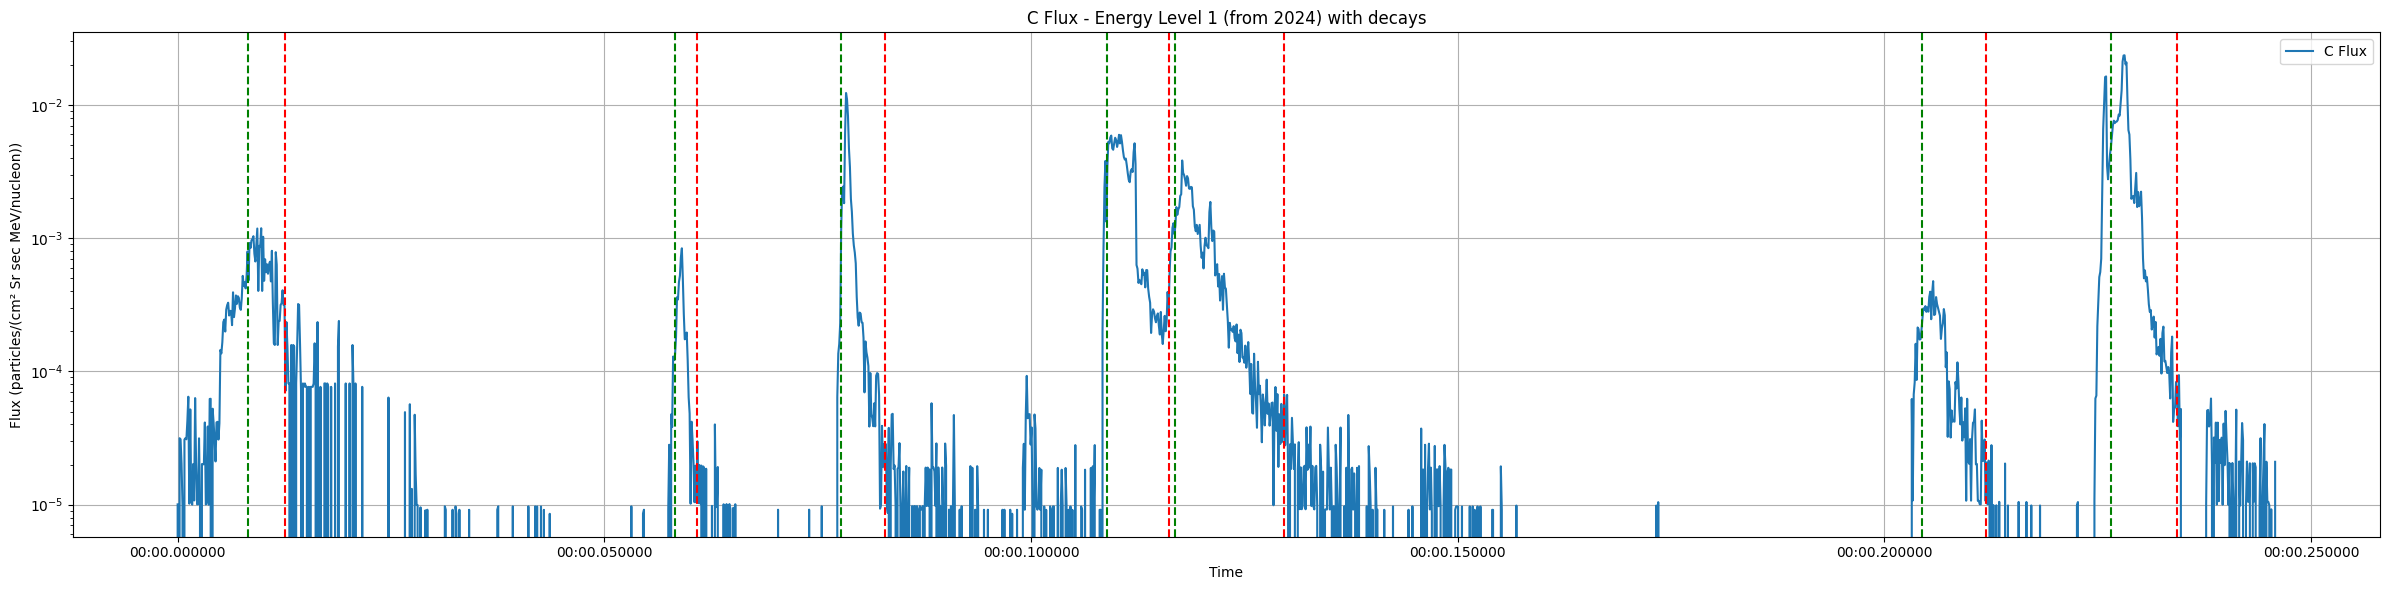

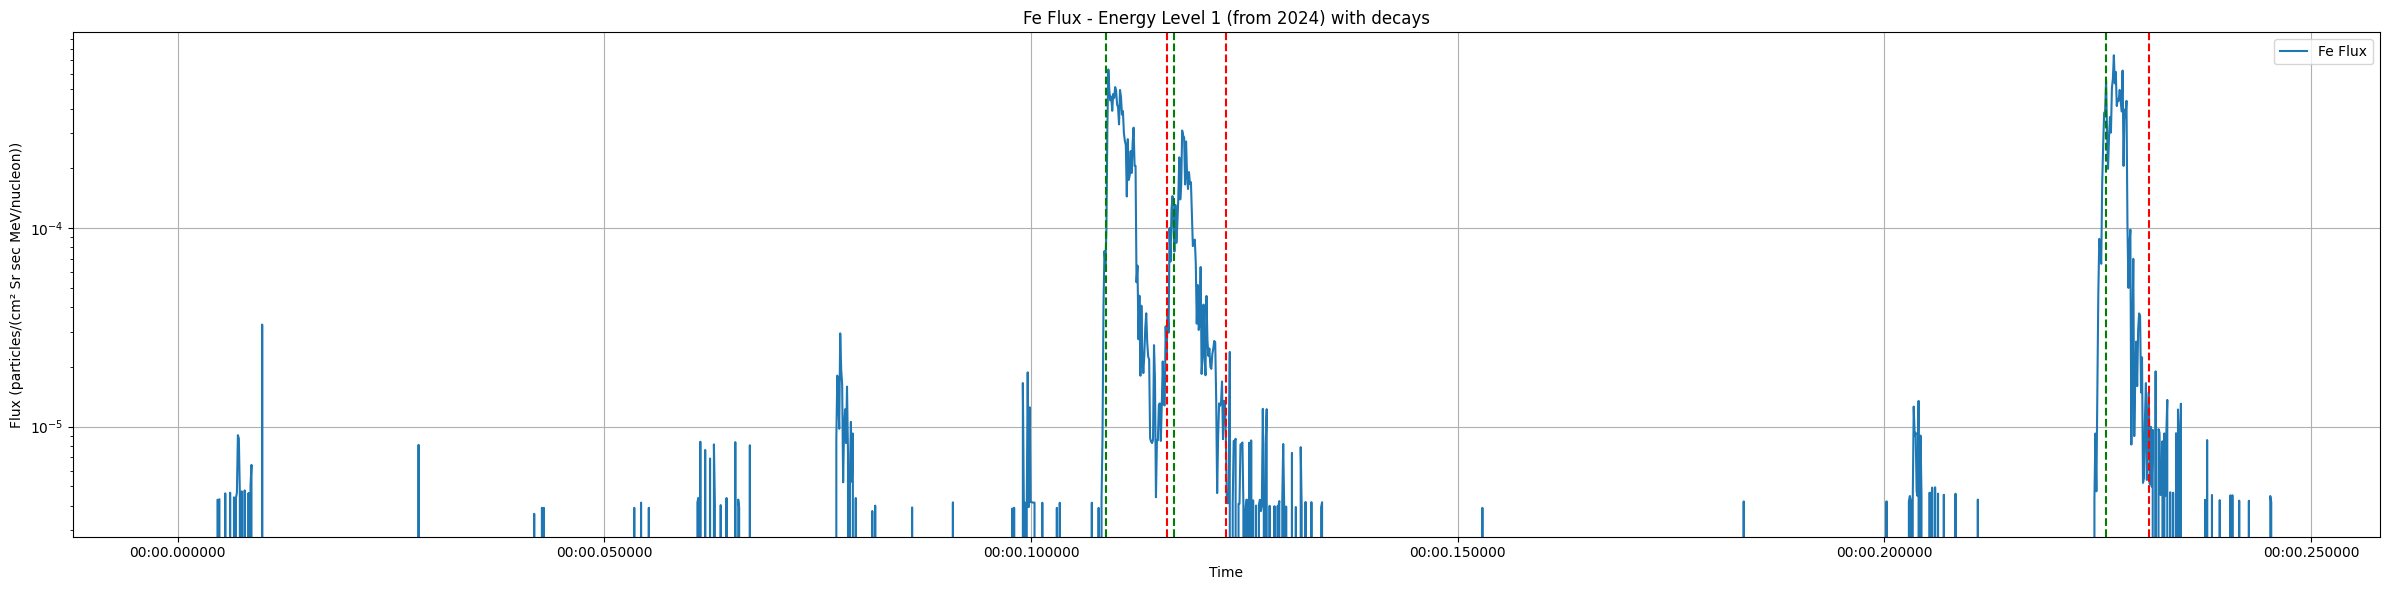

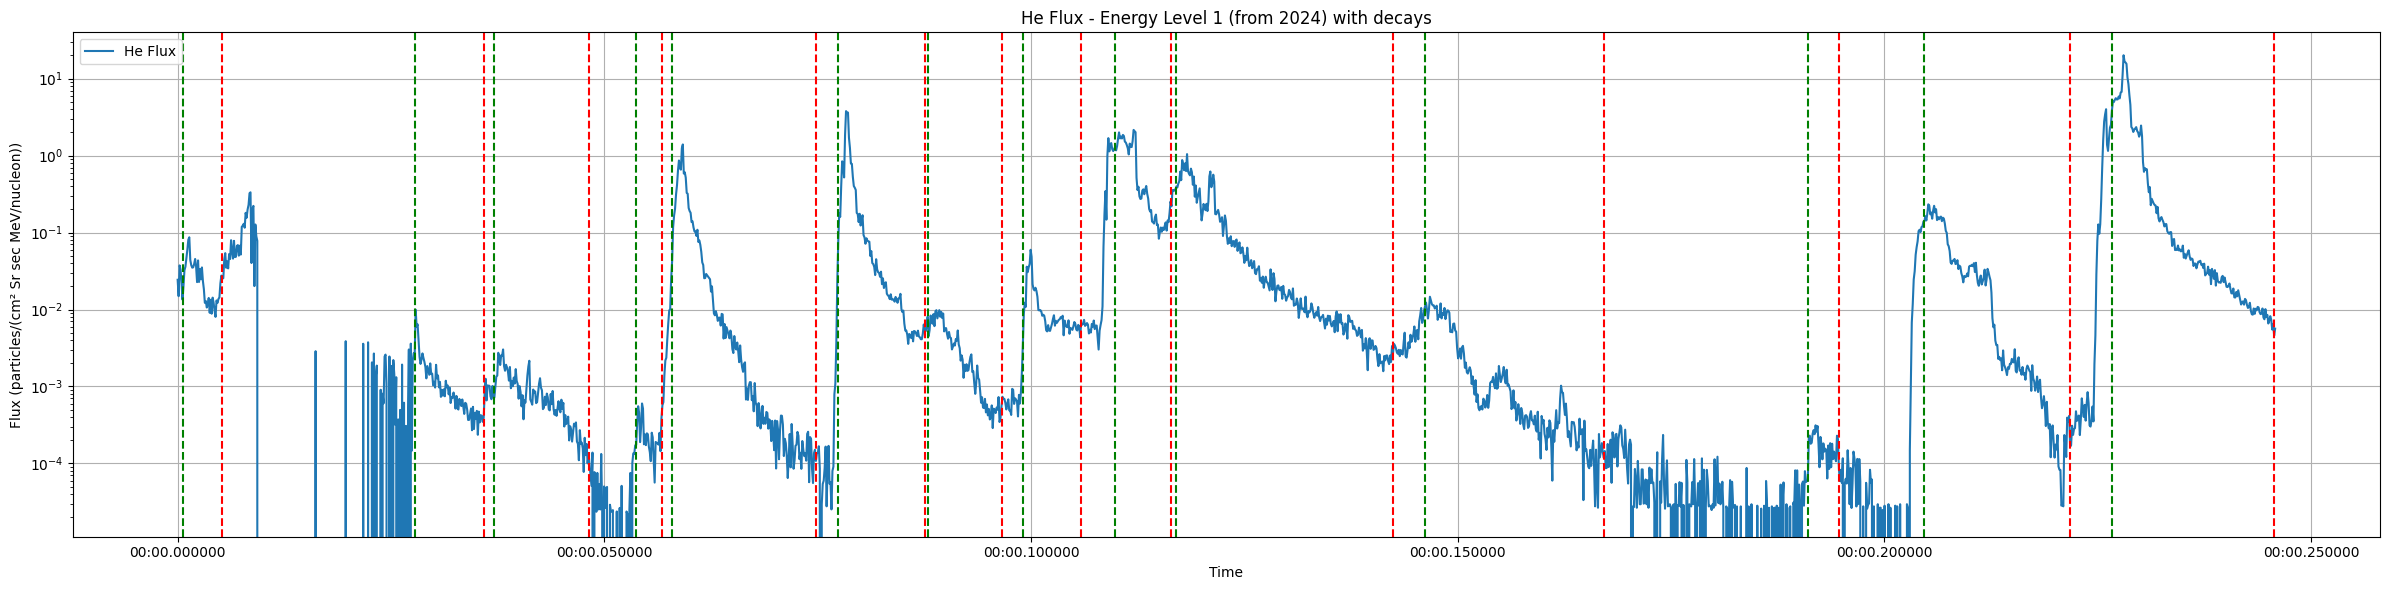

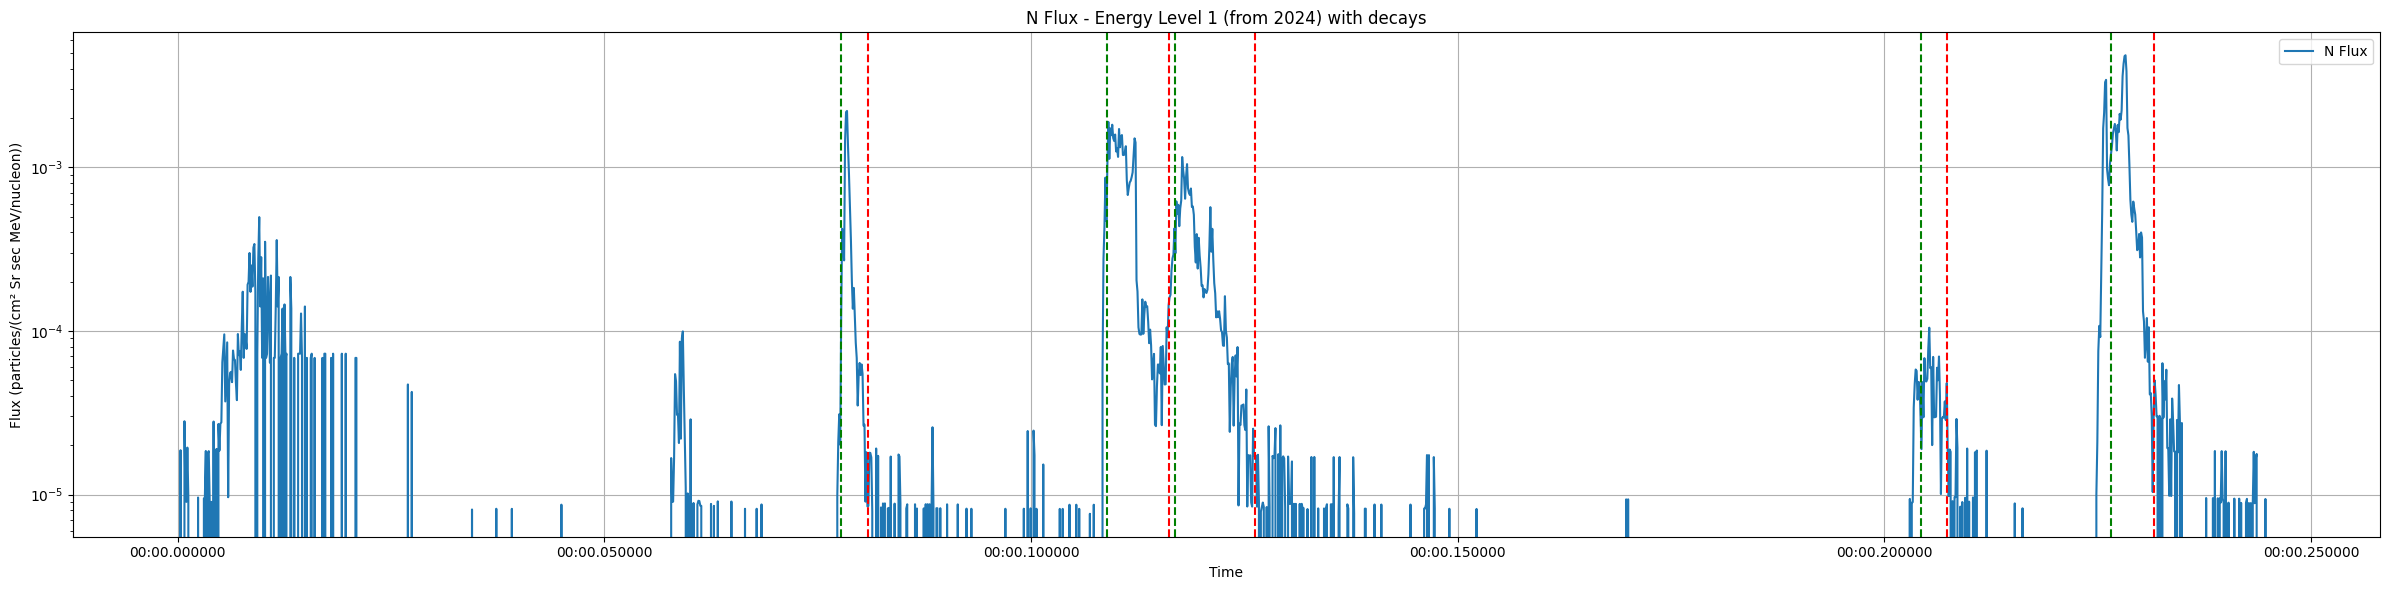

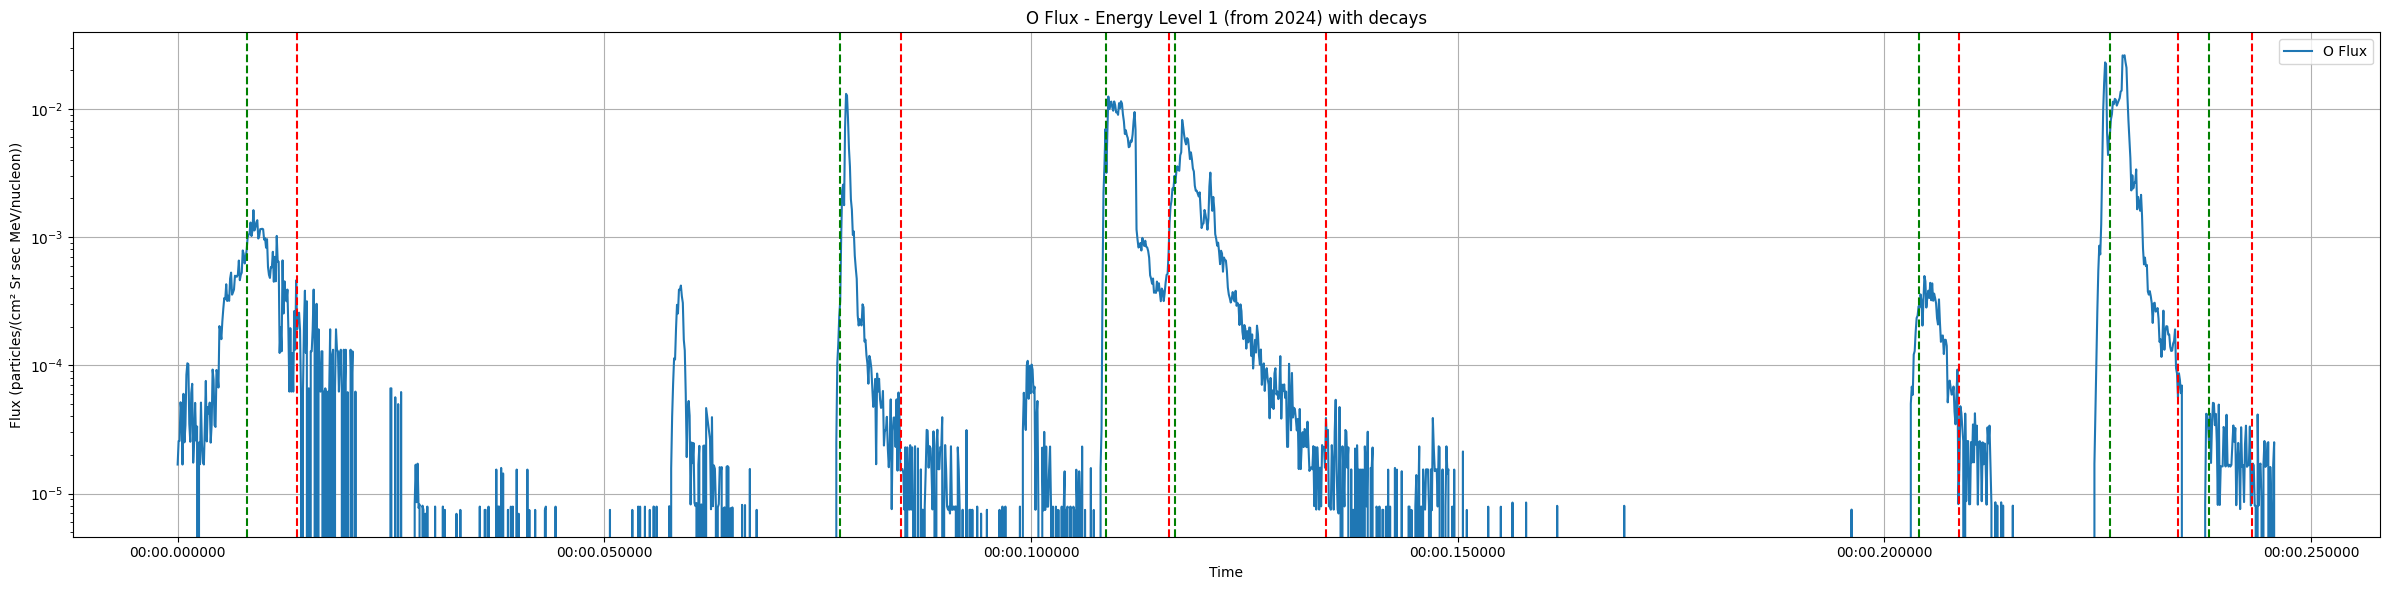

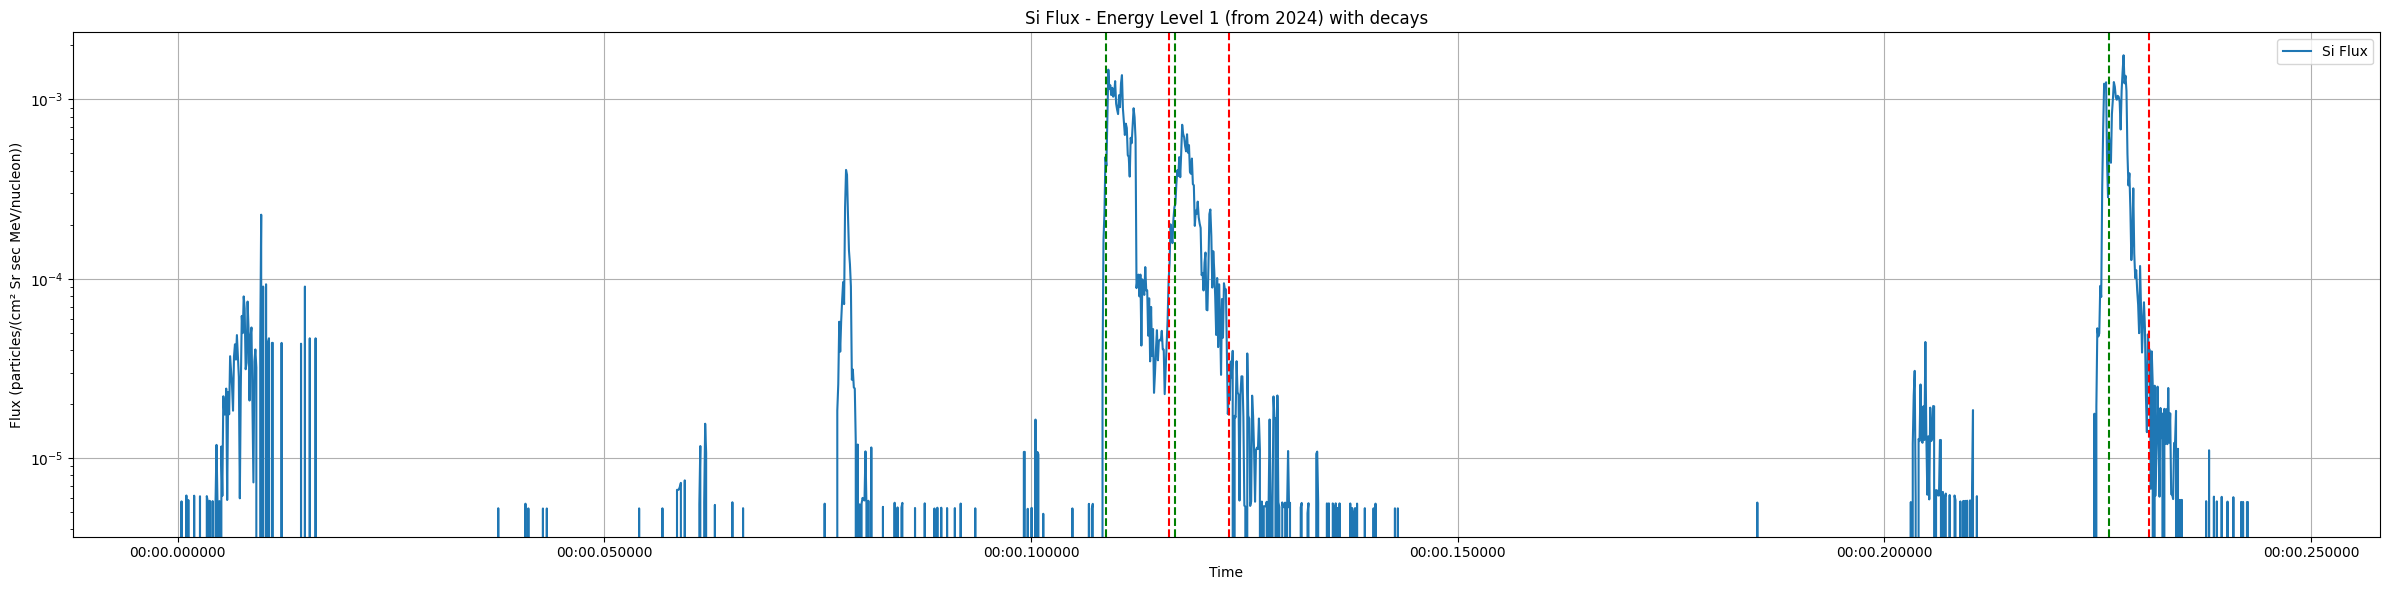

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress

def identify_exponential_decays(flux_data, time_data, window_size=24, slope_threshold=-0.005):
    """
    Identify exponential decay segments in flux data.

    Args:
        flux_data (numpy.ndarray): Array of flux values.
        time_data (numpy.ndarray): Array of corresponding datetime values.
        window_size (int): Size of the sliding window for linear regression (in hours).
        slope_threshold (float): Threshold for the slope to identify a decay.

    Returns:
        list: List of tuples containing start and end times of decay segments.
    """
    # Make sure flux_data contains no zero or negative values
    flux_data = np.where(flux_data > 0, flux_data, np.nan)
    log_flux_data = np.log10(flux_data)
    log_flux_data = gaussian_filter1d(log_flux_data, sigma=1)  # Smooth the data

    decays = []
    for i in range(len(log_flux_data) - window_size):
        window = log_flux_data[i:i + window_size]
        if np.isnan(window).any():
            continue
        slope, intercept, r_value, p_value, std_err = linregress(np.arange(window_size), window) #these vals may be used later

        if slope < slope_threshold:
            start_time = time_data[i]
            end_time = time_data[i + window_size - 1]
            decays.append((start_time, end_time))
    
    # Merge overlapping or adjacent decay segments
    merged_decays = []
    for start, end in decays:
        if merged_decays and start <= merged_decays[-1][1]:
            merged_decays[-1] = (merged_decays[-1][0], max(merged_decays[-1][1], end))
        else:
            merged_decays.append((start, end))
    
    return merged_decays

def plot_element_fluxes_with_decays_and_stats(data_3d, datetime_values, element_mapping, energy_level, start_time, end_time):
    """
    Plots separate graphs for flux data of each element at a specified energy level, 
    starting from a given year and omitting bad data. Includes statistical lines and decay segments.

    Args:
        data_3d (numpy.ndarray): The 3D data cube (energy, time, element).
        datetime_values (numpy.ndarray): Array of datetime objects for the time axis.
        element_mapping (dict): Dictionary mapping element names to array indices.
        energy_level (int): The energy level to plot.
        start_time (datetime): Start time for the analysis window.
        end_time (datetime): End time for the analysis window.
    """
    
    time_mask = (datetime_values >= start_time) & (datetime_values <= end_time)

    for element_name, element_index in element_mapping.items():
        plt.figure(figsize=(24, 6)) 

        element_flux = data_3d[energy_level - 1, time_mask, element_index]

        # Omit bad data points
        valid_data_mask = element_flux != -999.9
        element_flux = element_flux[valid_data_mask]
        element_time = datetime_values[time_mask][valid_data_mask]

        if len(element_flux) == 0:
            continue

        # Calculate statistics for the time window
        # median_flux = np.median(element_flux)
        # std_flux = np.std(element_flux)
        # noise_cutoff = median_flux + 2 * std_flux  

        # plt.axhline(median_flux, color='r', linestyle='--', label='Median')
        # plt.axhline(median_flux + std_flux, color='g', linestyle='-.', label='Median + STD')
        # plt.axhline(noise_cutoff, color='b', linestyle=':', label='Noise Cutoff (2*STD)')

        plt.plot(element_time, element_flux, label=f'{element_name} Flux')
        plt.yscale('log')

        # Identify exponential decay segments
        decay_segments = identify_exponential_decays(element_flux, element_time)

        for start, end in decay_segments:
            plt.axvline(start, color='g', linestyle='--', label='_nolegend_')
            plt.axvline(end, color='r', linestyle='--', label='_nolegend_')



        plt.xlabel('Time')
        plt.ylabel('Flux (particles/(cm² Sr sec MeV/nucleon))') 
        plt.title(f'{element_name} Flux - Energy Level {energy_level} (from {start_time.year}) with decays')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example usage
energy_level_to_plot = 1
start_time = pd.to_datetime('2024-01-01')
end_time = pd.to_datetime('2024-01-03')
plot_element_fluxes_with_decays_and_stats(all_flux_data, datetime_values, element_mapping, energy_level_to_plot, start_time, end_time)
